# Building a Neural Network from scratch

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict

## Import Data

In [4]:
mnist_test = pd.read_csv('MNIST_CSV/mnist_test.csv')
mnist_train = pd.read_csv('MNIST_CSV/mnist_train.csv')
mnist_test = np.array(mnist_test).T
mnist_train = np.array(mnist_train).T

## Test plot for a number

(-0.5, 27.5, 27.5, -0.5)

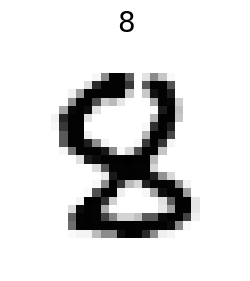

In [5]:
fig, ax = plt.subplots(figsize=(3, 3))
randint = np.random.randint(0, mnist_train.shape[1])
ax.imshow(np.reshape(mnist_train[1:, randint], (28, 28)), cmap='Greys')
ax.set_title(f"{mnist_train[0, randint]}", fontsize=20)
ax.axis('off') 

### Change single label into array of 0s and 1s, (one hot)

In [186]:
def one_hot(label):
    Y = np.zeros(10)
    Y[label] = 1
    return Y

## Coding one Neuron

In [7]:
class Neuron:
    def __init__(self, weight, biases, input):
        self.weight = weight
        self.biases = biases
        self.input = input
        self.output = 0 
    
    def forward(self) -> float:
        self.output = np.dot(self.input, self.weight) + self.biases
        return self.output

In [8]:
w = np.random.uniform(0, 5, 5)
b = np.random.uniform(0, 5, 5)
X_data = np.random.uniform(0, 100, 5)

neuron = Neuron(weight=w, biases=b, input=X_data)
output = neuron.forward()

print(output)

[829.04236558 831.16310972 827.93077964 828.65936913 829.3762739 ]


## Whole Network of hidden layers and neurons

In [768]:
def Linear(x, weights, bias):
    """Linear hidden layer"""
    return weights.dot(x) + bias

def ReLU(inputs) -> np.ndarray:
    """Activation function"""
    return np.maximum(0, inputs)

def softMax(inputs: np.ndarray) -> np.ndarray:
    exps = np.exp(inputs - inputs.max())
    return exps / np.sum(exps)

def initialise_weights(num_HL, HL_structure, num_inputs, num_outputs) -> (np.ndarray, np.ndarray):
    params = {"W0": np.random.normal(0, 2/num_inputs, size=(HL_structure[0], num_inputs))}
    for i in range(num_HL-1):
        params[f"W{i+1}"] = np.random.normal(0, 2/HL_structure[i], size=(HL_structure[i+1], HL_structure[i], ))
    params[f"W{num_HL}"] = np.random.normal(0, 2/HL_structure[-1], size=(num_outputs, HL_structure[-1]))
    biases = np.random.normal(size=num_HL+2)
    return params, biases

class NeuralNetwork:
    def __init__(self, num_inputs, hidden_layer_structure, num_outputs, lr=0.1):
        self.num_inputs = num_inputs
        self.num_hidden_layers = len(hidden_layer_structure)
        self.hidden_layer_structure = hidden_layer_structure
        self.num_outputs = num_outputs
        self.lr = lr
        
        # Randomly initialise weights and biases
        self.weights, self.biases = initialise_weights(num_HL=self.num_hidden_layers,
                                              HL_structure=self.hidden_layer_structure,
                                              num_inputs=self.num_inputs,
                                              num_outputs=self.num_outputs)
        
        # Information I may want
        self.num_nodes = self.num_hidden_layers + sum(hidden_layer_structure)

    def forward(self, As):
        Zs_dict = {}
        As_dict = {}
        for i, weights in enumerate(self.weights.values()):
            Zs = Linear(As, weights, self.biases[i])
            As = ReLU(Zs)

            Zs_dict[f"Z{i}"] = Zs
            As_dict[f"A{i}"] = As

        return Zs_dict, As_dict
    
    def update_weights(self, grad_w, grad_b):
        for i in range(len(self.weights)):
            self.weights[f"W{i}"] -= self.lr * grad_w[f"GW{i}"]
            self.biases[i] -= self.lr * grad_b[f"GB{i}"]

In [769]:
def cross_entropy(outputs, targets):
    """Classification Loss Function"""
    normalised_outputs = softMax(outputs)
    return - np.sum(targets * np.log(normalised_outputs))

def deriv_ReLU(x):
    ret = np.zeros_like(x)
    ret[x >= 0] = 1
    return ret

In [771]:
class Criterion:
    def __init__(self, NN):
        self.NN = NN
        self.params = self.NN.weights
        self.biases = self.NN.biases
        self.num_layers = len(self.params.keys())

    def backward(self, Zs, As, true_label, OG_array):
        m = 1
        grad_weights = {}
        grad_biases = {}

        # Initial layer
        true_one_hot = one_hot(true_label)
        dZ = (list(As.values())[-1] - true_one_hot)[:, None]
        dW = (1/m)*(dZ.dot(list(As.values())[-2][:, None].T))
        dB = (1/m)*(np.sum(dZ))

        grad_weights[f"GW{self.num_layers-1}"] = dW
        grad_biases[f"GB{self.num_layers-1}"] = dB

        # Hidden layers
        i = len(self.params.values())-2
        for weights in list(self.params.values())[::-1][:-1]:
            if i == 0:
                A = OG_array
            else:
                A = As[f"A{i-1}"]
            Z = Zs[f"Z{i}"]
            dZ = weights.T.dot(dZ) 
            dZ = dZ * deriv_ReLU(Z[:, None])

            dW = (1/m) * (dZ.dot(A[:, None].T))
            dB = (1/m) * (np.sum(dZ))

            grad_weights[f"GW{i}"] = dW
            grad_biases[f"GB{i}"] = dB
            i -= 1

        return grad_weights, grad_biases
        # [print(key, value.shape) for key, value in grad_weights.items()]
        # # [print(key, np.round(value, 2)) for key, value in grad_biases.items()]

In [772]:
randint = np.random.randint(0, mnist_train.shape[1])
rand_img = mnist_train[1:, randint]
true_label = mnist_train[0, randint]

NN = NeuralNetwork(num_inputs=rand_img.shape[0], hidden_layer_structure=[50, 25, 15], num_outputs=10)
c = Criterion(NN=NN)
Zs, As = NN.forward(rand_img)
grad_w, grad_b = c.backward(Zs=Zs, As=As, true_label=true_label, OG_array=rand_img)
NN.update_weights(grad_w=grad_w, grad_b=grad_b)

In [752]:
# class Criterion:
#     def __init__(self, NN):
#         self.NN = NN
#         self.params = NN.weights
        
#     def backward(self, Zs, As, INPUT, true_label):
#         one_hot_true_label = one_hot(true_label)

#         m = len(INPUT) 

#         dz = softMax(As[f"A{len(self.params)-1}"]) - one_hot_true_label
#         dw = (1/m) * dz[:, None].dot(As[f"A{len(self.params)-2}"][:, None].T)
#         grad_w = {f"W{len(self.params)-1}": dw}

#         for i in range(len(self.params)-2, 0, -1):
#             m = len(Zs[f"Z{i+1}"])
#             dz = self.params[f"W{i+1}"].T.dot(dz * deriv_ReLU(Zs[f"Z{i+1}"]))
#             dw = (1/m) * dz[:, None].dot(As[f"A{i-1}"][:, None].T)
#             grad_w[f"W{i}"] = dw
#         dz = self.params[f"W{i}"].T.dot(dz * deriv_ReLU(Zs[f"Z{i}"]))
#         dw = (1/m) * dz[:, None].dot(INPUT[:, None].T)
#         grad_w[f"W{i-1}"] = dw
#         return grad_w, {}

In [753]:
# rand_num = mnist_train[1:, randint]
# true_label = mnist_train[0, randint]

# NN = NeuralNetwork(num_inputs=784,
#                    hidden_layer_structure=[784, 10],
#                    num_outputs=10)
# loss = Criterion(NN)
# Zs, As = NN.forward(rand_num)
# [print(key, value.shape) for key, value in Zs.items()]
# [print(key, value.shape) for key, value in As.items()]
# [print(key, value.shape) for key, value in NN.weights.items()]
# grad_w, grad_b = loss.backward(Zs, As, rand_num, true_label)
# NN.update_weights(grad_w=grad_w,grad_b=grad_b)

In [776]:
HLS = [10]
NN = NeuralNetwork(num_inputs=784, hidden_layer_structure=HLS, num_outputs=10, lr=0.1)
loss = Criterion(NN=NN)

num_epochs = 10
for epoch in range(num_epochs):
    for i, img in enumerate(mnist_train.T):
        label = img[0]
        data = img[1:]
        Zs, As = NN.forward(data)
        grad_w, grad_b = loss.backward(Zs=Zs, As=As, true_label=label, OG_array=data)
        NN.update_weights(grad_w=grad_w, grad_b=grad_b)
        if i % 1000 == 0:
            error = cross_entropy(outputs=list(As.values())[-1], targets=one_hot(label=label))
            print(f"Training... | Error: {error} | Epoch {epoch + 1}/{num_epochs} | Image {i} / {mnist_train.shape[1]}", end="\r")

In [ ]:
for i, img in enumerate(mnist_test.T):
    label = img[0]
    data = img[1:]
    Zs, As = NN.forward(data)
    guess = softMax(list(As.values())[-1])
    

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

[0.1 0.1 0.1 0.1 0.1 0.1 